In [6]:
# Standard Libraries
from collections import Counter
from itertools import product
import os
from os import listdir, path

# Third-Party Libraries
from matplotlib import patheffects
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Patch, Rectangle
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import numpy as np
import pandas as pd

pd.options.display.max_columns = 500
import warnings
warnings.filterwarnings("ignore")


def parse_kinetic(x):        
    if x in com_map:
        return com_map[x]
    prefix = x.split('_')[0]
    if prefix == 'AVG':        
        marker = x.split('_')[1]
        marker = markername_map[marker].replace('estimated','est.')
        return '%s\n[mean up to day 2]'%(marker)
    
    prefix,marker,suffix = x.split('_')    
    marker = markername_map[marker].replace('estimated','est.')    
    if prefix == 'NA':
        op = '[REQ. D%s]'%suffix
    if prefix == 'lab':
        op = '[D%s]'%suffix
    if prefix =='delta':
        op = '[D%s-D0]'%suffix
    if prefix == 'kindiff':
        op = '[D%s-D%s]'%(suffix[0],suffix[2])
    if prefix =='deltaratio':
        #op = '[D%s/D0]'%suffix
        op = '[ratio D%s to D0]'%suffix
    if prefix == 'kinratio':
        # op = '[D%s/D%s]'%(suffix[0],suffix[2])
        op = '[ratio D%s to D%s]'%(suffix[0],suffix[2])
    if prefix =='deltaabs':
        op = 'abs(D%s-D0)'%suffix
    if prefix == 'kinabs':
        op = 'abs(D%s-D%s)'%(suffix[0],suffix[2])
    if prefix =='deltasign':
        op = 'sign(D%s-D0)'%suffix
    if prefix == 'kinsign':
        op = 'sign(D%s-D%s)'%(suffix[0],suffix[2])
    return '%s\n%s'%(marker,op)

In [2]:
input_path = 'data'

In [9]:
acr = pd.read_excel(path.join(input_path,'marker_translations.xlsx'))
marker_map = {}
for x in acr[['German Acronym','English Acronym']].itertuples():
    marker_map[x._1] = x._2    
markername_map = {}
for x in acr[['German Acronym','Description in English']].itertuples():
    markername_map[x._1] = x._2    
    
com_map = {
    'com_charlson_MyocardialInfarction': 'myocardial infarction',
    'com_charlson_CongestiveHeartFailure': 'congestive heart failure',
    'com_charlson_PeripheralVascularDisease': 'peripheral vascular disease',
    'com_charlson_CerebrovascularDisease': 'cerebrovascular disease',
    'com_charlson_Dementia': 'dementia',
    'com_charlson_ChronicPulmonaryDisease': 'chronic pulmonary disease',
    'com_charlson_ConnectiveTissueDiseaseRheumaticDisease': 'rheumatic disease',
    'com_charlson_PepticUlcerDisease': 'peptic ulcer disease',
    'com_charlson_MildLiverDisease': 'mild liver disease',
    'com_charlson_ParaplegiaHemiplegia': 'paraplegia/hemiplegia',
    'com_charlson_RenalDisease': 'moderate/severe liver disease',
    'com_charlson_Cancer': 'cancer',
    'com_charlson_MetastaticCarcinoma': 'metastatic carcinoma',
    'com_charlson_HIV': 'HIV',
    'com_elix_CardiacArrhythmia': 'cardiac arrhythmia',
    'com_elix_ValvularDisease': 'valvular disease',
    'com_elix_PulmonaryCirculationDisorders': 'pulmonary circulation disorders',
    'com_elix_HypertensionUncomplicated': 'hypertension uncomplicated',
    'com_elix_HypertensionComplicated': 'hypertension complicated',
    'com_elix_OtherNeurologicalDisorders': 'other neurological disorders',
    'com_elix_Hypothyroidism': 'hypothyroidism',
    'com_elix_LiverDisease': 'liver disease',
    'com_elix_Lymphoma': 'lymphoma',
    'com_elix_SolidTumorNoMetastasis': 'solid tumor no metastasis',
    'com_elix_RheumatoidArthritis': 'rheumatoid arthritis',
    'com_elix_Coagulopathy': 'coagulopathy',
    'com_elix_WeightLoss': 'weight loss',
    'com_elix_FluidEcletrolyteDisorders': 'fluid electrolyte disorders',
    'com_elix_DeficiencyAnemia': 'deficiency anemia',
    'com_elix_AlcoholAbuse': 'alcohol abuse',
    'com_elix_DrugAbuse': 'drug abuse',
    'com_elix_Psychoses': 'psychoses',
    'com_elix_Depression': 'depression',
    'age':'age',
    'sex':'sex',
    'asa':'ASA score',
    'emergencysurgery':'emergency op',
    'atb_preop':'antibiotics preOp',
    'imcib':'moved to ICU',
    'night_surg':'night Op',
    'duration_of_surg':'op duration (min)',
    'vascular': 'vascular',
    'visceral': 'visceral',
    'ORL':'ENT',
    'gynecology': 'gynaecology',
    'neuro':'neurosurgery',
    'ophthalmology': 'ophthalmology',
    'ortho': 'orthopaedic/trauma',
    'pediatric': 'paediatric',
    'plastic_hand': 'plastic/hand',
    'thoracic': 'thoracic',
    'urology':'urology',
    'dermatology': 'dermatology'
}

In [12]:
df_shap = pd.read_csv(path.join(input_path,'shap_data.csv'))
sorted_features = df_shap.abs().mean().sort_values(ascending=False).index

df_features = pd.read_csv(path.join(input_path,'df_features.csv'))
feature_values_normalized = (df_features - df_features.min()) / (df_features.max() - df_features.min())

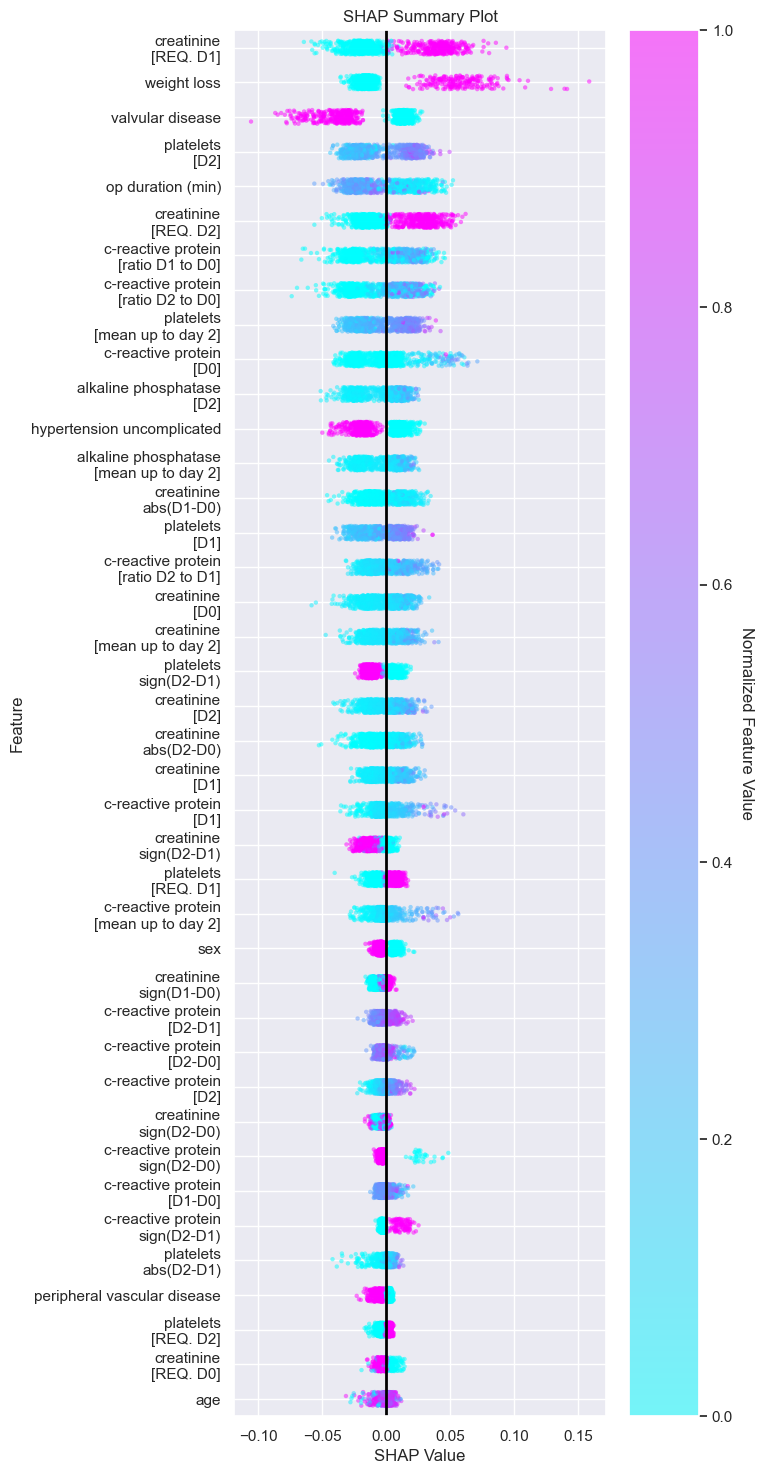

In [13]:
sns.set_style('whitegrid')
sns.set(font_scale=1)
fig,ax = plt.subplots(figsize=(6, 18))
_K = 40
for i, feature in enumerate(sorted_features[:_K]):
    shap_vals = df_shap[feature].values        
    colors = feature_values_normalized[feature].values      
    jitter = np.random.uniform(low=-0.2, high=0.2, size=len(shap_vals))
    plt.scatter(shap_vals, [i + x for x in jitter], c=colors, cmap='cool', alpha=0.5, edgecolor='none', s=10, vmin=0, vmax=1)

ax.axvline(x=0,color='black',lw=2)
plt.yticks(range(len(sorted_features[:_K])), [parse_kinetic(x) for x in sorted_features[:_K]])
plt.ylim(-.5,_K-.5)
cbar = plt.colorbar()
cbar.set_label('Normalized Feature Value', rotation=270, labelpad=15)

plt.xlabel('SHAP Value')
plt.ylabel('Feature')
plt.title('SHAP Summary Plot')
plt.gca().invert_yaxis()
plt.show()